# Project 2

# Part 1
## Part 1.1

In [82]:
# Helper Stuff
import numpy as np
from pathlib import Path
import skimage as sk
import cv2 as cv
import skimage.io as skio
import skimage.color as skcolor
import scipy.signal as scsignal
import matplotlib.pyplot as plt
import time

# 9x9 Kernel
kernel_9x9 = np.ones((9, 9)) / 81

# Difference Operatores
D_x = np.array([[1, 0, -1]])
D_y = np.array([[1], [0], [-1]])


def load_image(path, greyscale=True):
    im = skio.imread(path)
    im = sk.img_as_float(im)
    
    # remove alpha if its there
    if im.shape[-1] == 4:
        im = skcolor.rgba2rgb(im)

    if greyscale and im.ndim == 3:
        im = skcolor.rgb2gray(im)
    return im

def crop_to_center(image, dimension):
    start_row = (image.shape[0] - dimension[0]) // 2
    start_col = (image.shape[1] - dimension[1]) // 2
    return image[start_row:start_row + dimension[0], start_col:start_col + dimension[1]]

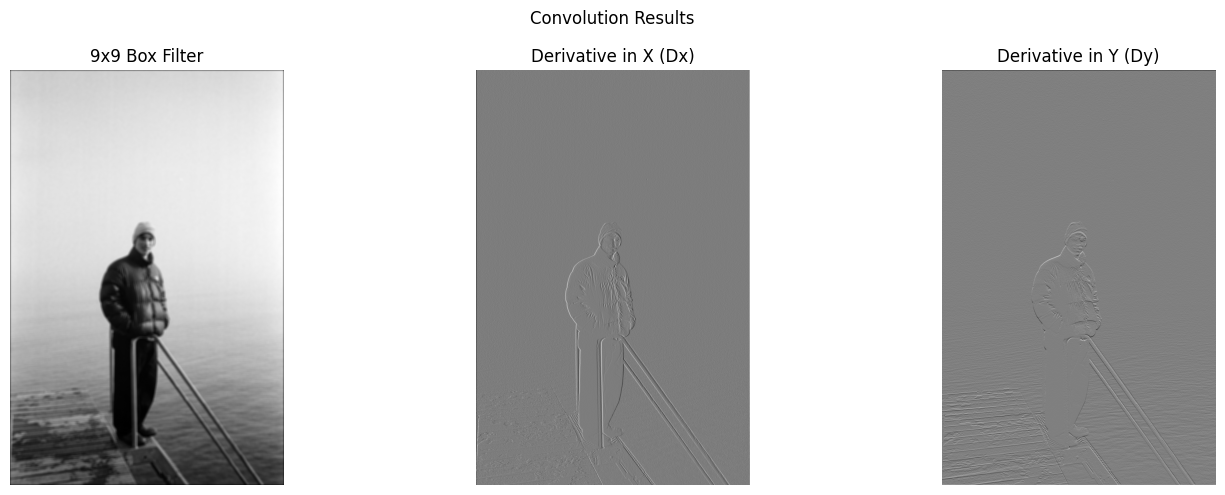

Four-Loop Convolution Time: 54.2270 seconds
Two-Loop Convolution Time: 9.2138 seconds
Built-in Time: 0.2505 seconds


In [4]:
#Part 1: Fun with Filters
def convolve_four_loops(image, kernel):
    im_height, im_width = image.shape
    k_height, k_width = kernel.shape

    pad_h = k_height // 2
    pad_w = k_width // 2

    pad_im = np.zeros((im_height + 2*pad_h, im_width + 2*pad_w))
    pad_im[pad_h : im_height + pad_h, pad_w: im_width + pad_w] = image

    convolved = np.zeros_like(image)

    for j in range(im_height):
        for i in range(im_width):
            total_product = 0.0

            for kj in range(k_height):
                for ki in range(k_width):
                    img_j = j + kj
                    img_i = i + ki

                    product = pad_im[img_j, img_i] * kernel[kj, ki]
                    total_product += product
            
            convolved[j, i] = total_product

    return convolved
    
def convolve_two_loops(image, kernel):
    im_height, im_width = image.shape
    k_height, k_width = kernel.shape

    pad_h = k_height // 2
    pad_w = k_width // 2

    pad_im = np.zeros((im_height + 2*pad_h, im_width + 2*pad_w))
    pad_im[pad_h : im_height + pad_h, pad_w: im_width + pad_w] = image

    convolved = np.zeros_like(image)

    for j in range(im_height):
        for i in range(im_width):
            extracted_patch = pad_im[j : j + k_height, i : i + k_width]
            convolved[j, i] = np.sum(extracted_patch * kernel)

    return convolved

# load image
path = './self_picture.png'
im = load_image(path, greyscale=True)

# Four For-Loops
start_four = time.perf_counter()
convolved_four_9x9 = convolve_four_loops(im, kernel_9x9)
end_four = time.perf_counter()
convolved_four_Dx = convolve_four_loops(im, D_x)
convolved_four_Dy = convolve_four_loops(im, D_y)

# Two For-Loops
start_two = time.perf_counter()
convolved_two_9x9 = convolve_two_loops(im, kernel_9x9)
end_two = time.perf_counter()
convolved_two_Dx = convolve_two_loops(im, D_x)
convolved_two_Dy = convolve_two_loops(im, D_y)

# Built-in
builtin_start = time.perf_counter()
convolved_builtin = scsignal.convolve2d(im, kernel_9x9)
builtin_end = time.perf_counter()

# Timings
elapsed_four = end_four - start_four
elapsed_two = end_two - start_two
elapsed_builtin = builtin_end-builtin_start


# Plot Images
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(convolved_four_9x9, cmap='gray')
axs[0].set_title('9x9 Box Filter')
axs[0].axis('off')

axs[1].imshow(convolved_four_Dx, cmap='gray')
axs[1].set_title('Derivative in X (Dx)')
axs[1].axis('off')

axs[2].imshow(convolved_four_Dy, cmap='gray')
axs[2].set_title('Derivative in Y (Dy)')
axs[2].axis('off')

fig.suptitle('Convolution Results')
plt.tight_layout()
plt.show()

# Print the timing results
print(f"Four-Loop Convolution Time: {elapsed_four:.4f} seconds")
print(f"Two-Loop Convolution Time: {elapsed_two:.4f} seconds")
print(f"Built-in Time: {elapsed_builtin:.4f} seconds")

## Part 1.2

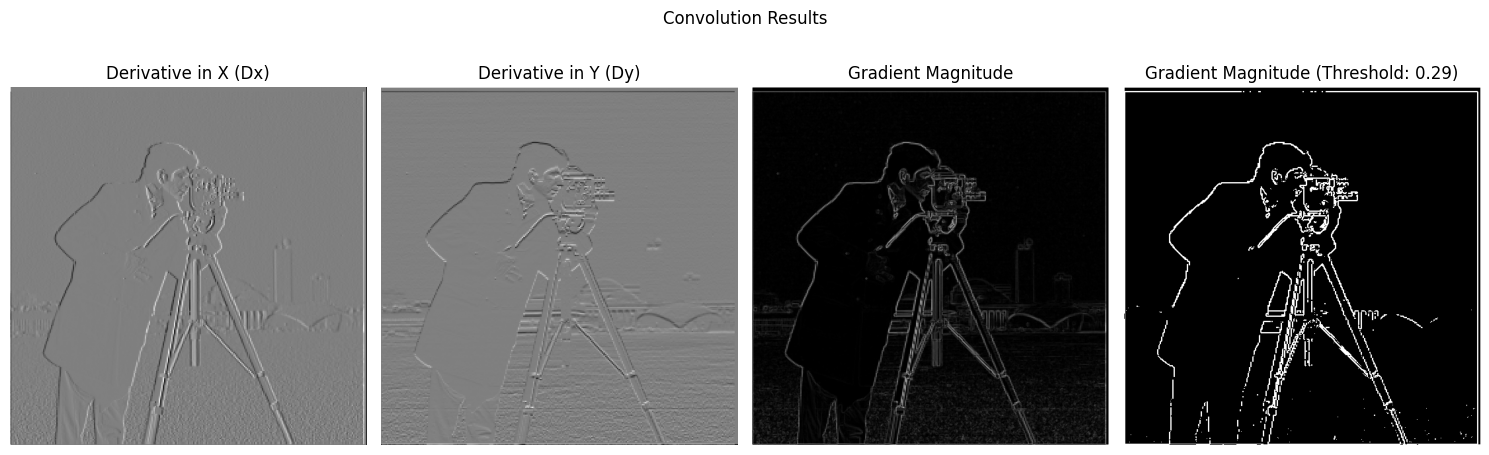

In [87]:
# Load cameraman
path = './cameraman.png'
cameraman = load_image(path, greyscale=True)
cameraman_shape = cameraman.shape

D_x_convolve = scsignal.convolve2d(cameraman, D_x, mode='full')
D_y_convolve = scsignal.convolve2d(cameraman, D_y, mode='full')
D_x_convolve = crop_to_center(D_x_convolve, cameraman_shape)
D_y_convolve = crop_to_center(D_y_convolve, cameraman_shape)

gradient_magnitude = np.sqrt(D_x_convolve**2 + D_y_convolve**2)

# Threshold the gradient
threshold = 0.29
threshold_gradient = gradient_magnitude > threshold

# Plot Images
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

axs[0].imshow(D_x_convolve, cmap='gray')
axs[0].set_title('Derivative in X (Dx)')
axs[0].axis('off')

axs[1].imshow(D_y_convolve, cmap='gray')
axs[1].set_title('Derivative in Y (Dy)')
axs[1].axis('off')

axs[2].imshow(gradient_magnitude, cmap='gray')
axs[2].set_title('Gradient Magnitude')
axs[2].axis('off')

axs[3].imshow(threshold_gradient, cmap='gray')
axs[3].set_title(f"Gradient Magnitude (Threshold: {threshold})")
axs[3].axis('off')

fig.suptitle('Convolution Results')
plt.tight_layout()
plt.show()

## Part 1.3

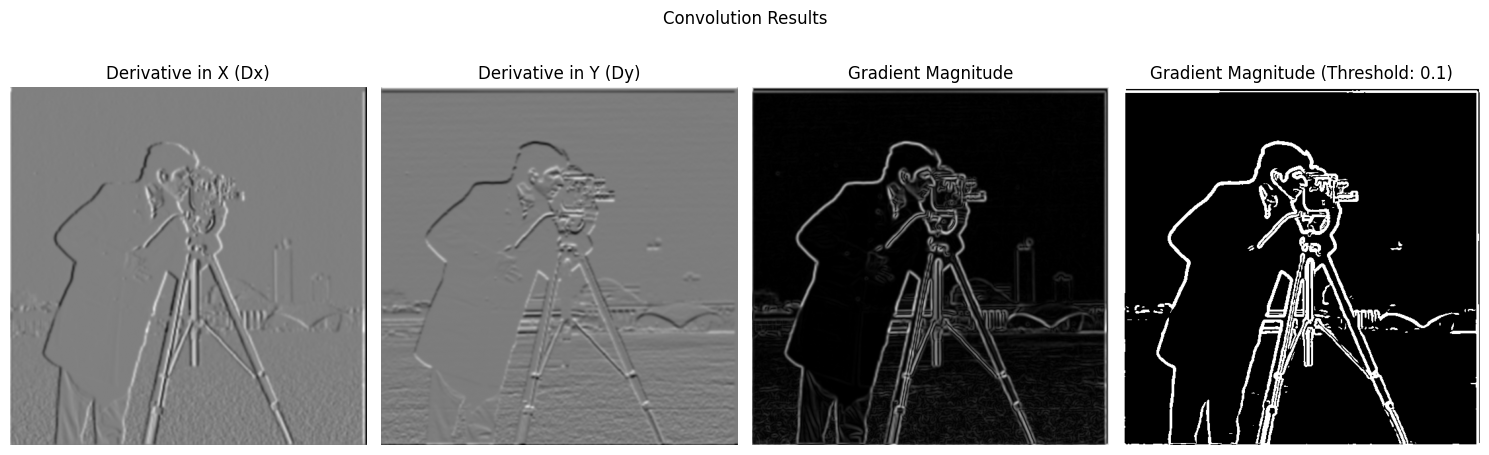

In [88]:
sigma = 1.5
rounded_size = round(6 * sigma)
k_size  =  rounded_size if rounded_size % 2 != 0 else rounded_size + 1

# Create Gaussian Filter
g_1d = cv.getGaussianKernel(k_size, sigma)
g_kernel = np.outer(g_1d, g_1d.T)

# Convolve with original image
cameraman_gaussian = scsignal.convolve2d(cameraman, g_kernel, mode='full')

# Repeat 1.2
D_x_convolve_gaussian = scsignal.convolve2d(cameraman_gaussian, D_x, mode='full')
D_y_convolve_gaussian = scsignal.convolve2d(cameraman_gaussian, D_y, mode='full')

D_x_convolve_gaussian = crop_to_center(D_x_convolve_gaussian, cameraman_shape)
D_y_convolve_gaussian = crop_to_center(D_y_convolve_gaussian, cameraman_shape)

gradient_magnitude_gaussian = np.sqrt(D_x_convolve_gaussian**2 + D_y_convolve_gaussian**2)

# Threshold the gradient
threshold_gaussian = 0.10
threshold_gradient_gaussian = gradient_magnitude_gaussian > threshold_gaussian

# Plot Images
fig, axs = plt.subplots(1, 4, figsize=(15, 5))

axs[0].imshow(D_x_convolve_gaussian, cmap='gray')
axs[0].set_title('Derivative in X (Dx)')
axs[0].axis('off')

axs[1].imshow(D_y_convolve_gaussian, cmap='gray')
axs[1].set_title('Derivative in Y (Dy)')
axs[1].axis('off')

axs[2].imshow(gradient_magnitude_gaussian, cmap='gray')
axs[2].set_title('Gradient Magnitude')
axs[2].axis('off')

axs[3].imshow(threshold_gradient_gaussian, cmap='gray')
axs[3].set_title(f"Gradient Magnitude (Threshold: {threshold_gaussian})")
axs[3].axis('off')

fig.suptitle('Convolution Results')
plt.tight_layout()
plt.show()

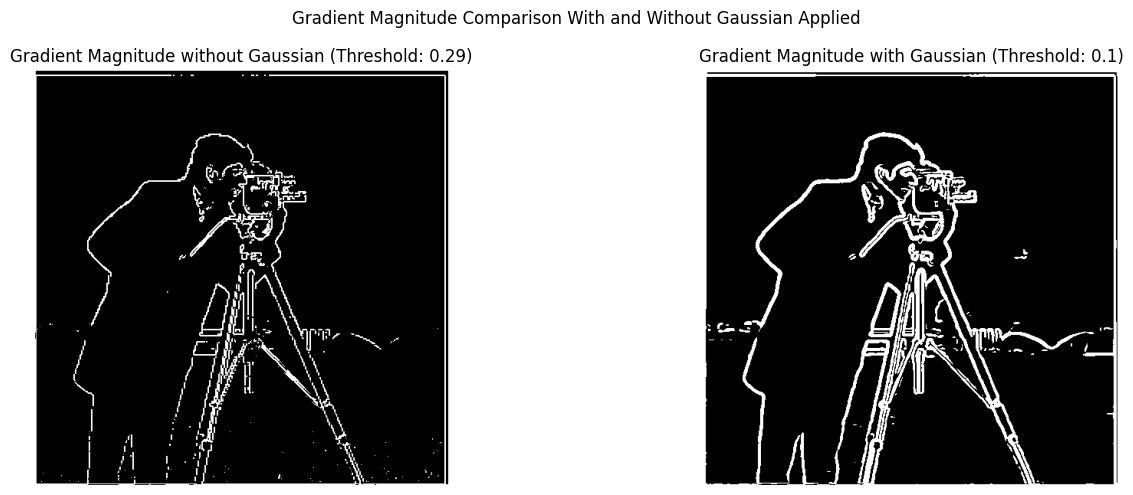

In [89]:
# Compare gradients
fig2, axs2 = plt.subplots(1, 2, figsize=(15, 5))

axs2[0].imshow(threshold_gradient, cmap='gray')
axs2[0].set_title(f"Gradient Magnitude without Gaussian (Threshold: {threshold})")
axs2[0].axis('off')

axs2[1].imshow(threshold_gradient_gaussian, cmap='gray')
axs2[1].set_title(f"Gradient Magnitude with Gaussian (Threshold: {threshold_gaussian})")
axs2[1].axis('off')

fig2.suptitle('Gradient Magnitude Comparison With and Without Gaussian Applied')
plt.tight_layout()
plt.show()

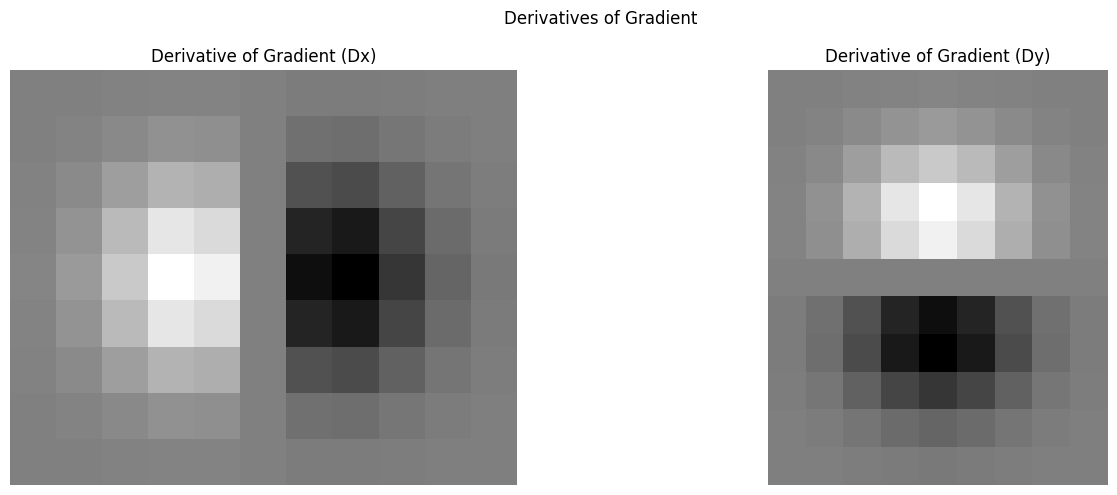

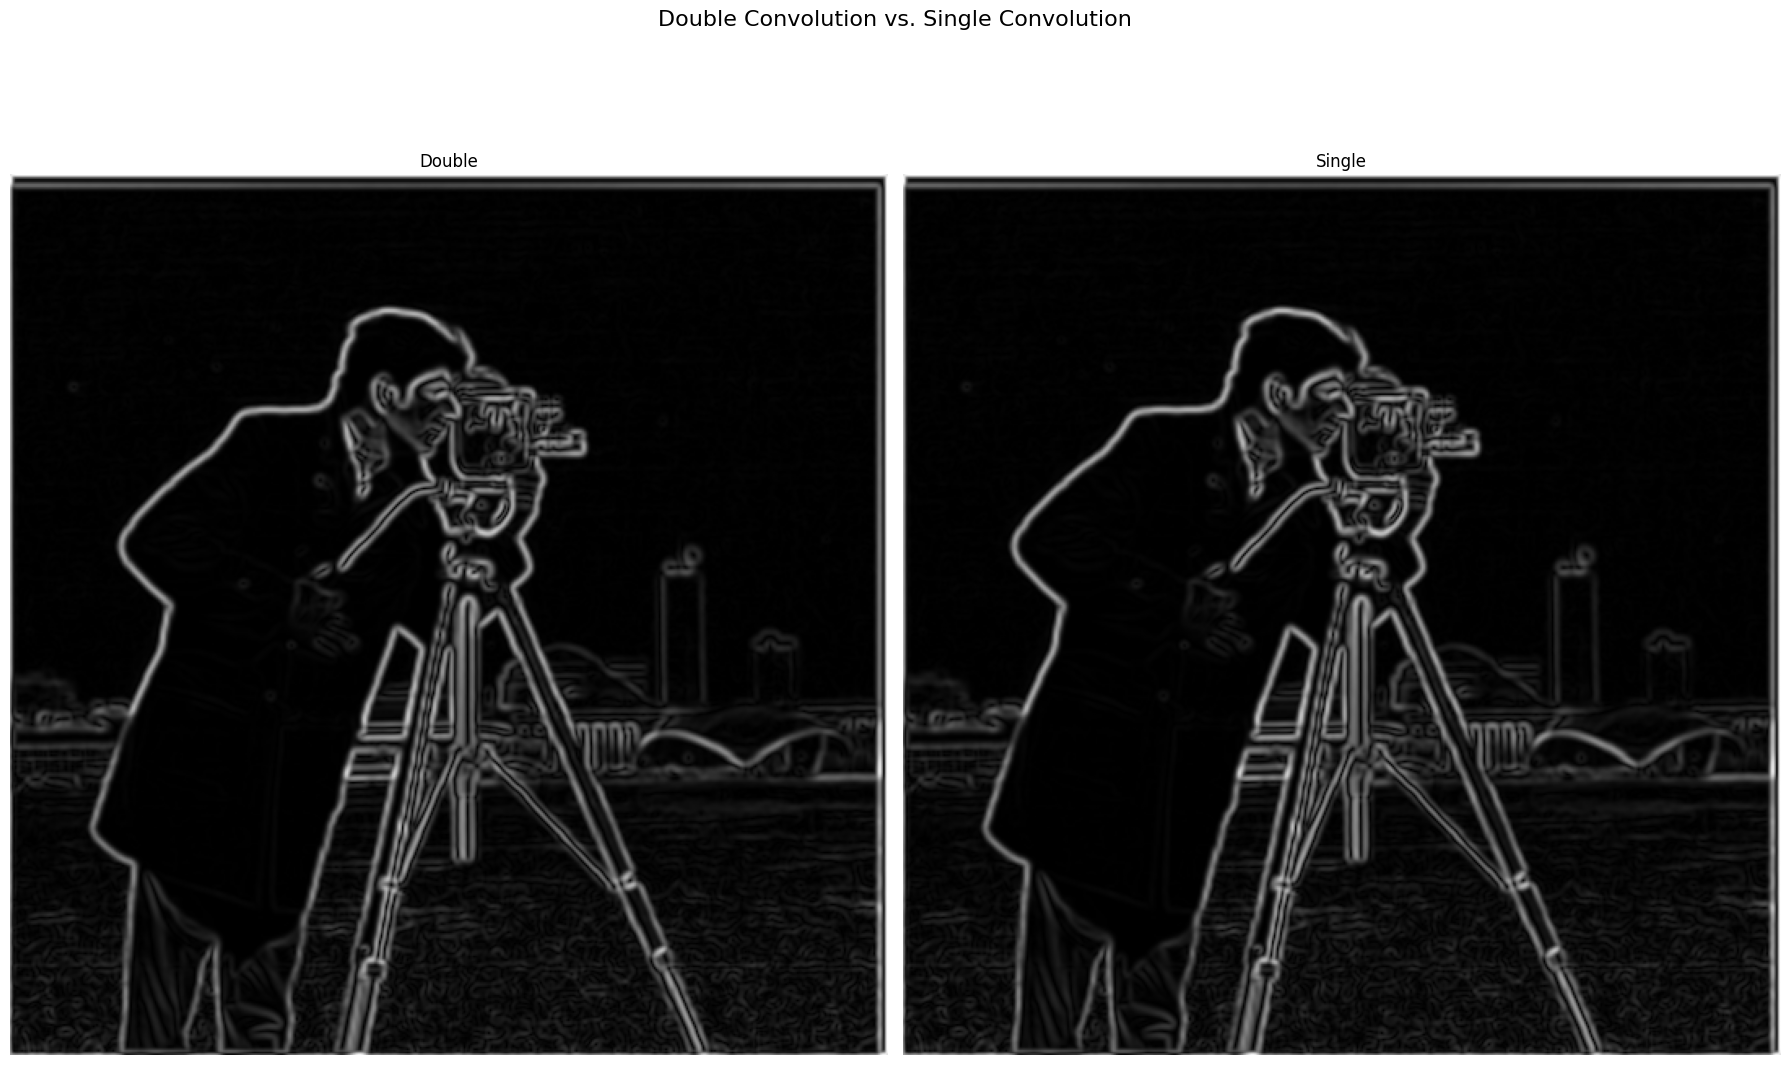

Identical? True


In [90]:
# Perform Single Convolution

DoG_x = scsignal.convolve2d(g_kernel, D_x, mode='full')
DoG_y = scsignal.convolve2d(g_kernel, D_y, mode='full')

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

axs[0].imshow(DoG_x, cmap='gray')
axs[0].set_title("Derivative of Gradient (Dx)")
axs[0].axis('off')

axs[1].imshow(DoG_y, cmap='gray')
axs[1].set_title("Derivative of Gradient (Dy)")
axs[1].axis('off')

fig.suptitle('Derivatives of Gradient')
plt.tight_layout()
plt.show()

cameraman_dog_x = scsignal.convolve2d(cameraman, DoG_x, mode='full')
cameraman_dog_y = scsignal.convolve2d(cameraman, DoG_y, mode='full')
cameraman_dog_x = crop_to_center(cameraman_dog_x, cameraman_shape)
cameraman_dog_y = crop_to_center(cameraman_dog_y, cameraman_shape)
gradient_mag_dog = np.sqrt(cameraman_dog_x**2 + cameraman_dog_y**2)

fig, axs = plt.subplots(1, 2, figsize=(18, 12))

axs[0].imshow(gradient_magnitude_gaussian, cmap='gray')
axs[0].set_title(f"Double")
axs[0].axis('off')

axs[1].imshow(gradient_mag_dog, cmap='gray')
axs[1].set_title(f"Single")
axs[1].axis('off')

fig.suptitle('Double Convolution vs. Single Convolution', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

are_identical = np.allclose(gradient_magnitude_gaussian, gradient_mag_dog)
print(f"Identical? {are_identical}")


# Part 2
## Part 2.1